## Work
### 請結合前面的知識與程式碼，比較不同的 regularization 的組合對訓練的結果與影響：如 dropout, regularizers, batch-normalization 等

In [0]:
import os
import keras
import itertools
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""
from keras.regularizers import l1, l2, l1_l2

In [0]:
train, test = keras.datasets.cifar10.load_data()

In [0]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [86]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train, flatten=True)
x_test = preproc_x(x_test, flatten=True)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

print(x_train.shape)
print(y_train.shape)

(50000, 3072)
(50000, 10)


In [0]:
def build_mlp(input_shape, drop_rate, regularizer, hidden_layer=2, num_nurons=[512, 256, 128]):
       
    input_layer = keras.layers.Input(input_shape)

    for i, units in enumerate(num_nurons):
      if i==0: 
        x = keras.layers.Dense(units=512, activation="relu", name="input_layer")(input_layer)
        x = keras.layers.BatchNormalization()(x)
      else:
        x = keras.layers.Dense(units=512, activation="relu", name="hidden_layer"+str(i))(x)
        x = keras.layers.BatchNormalization()(x)

    output_layer = keras.layers.Dense(units=10, activation="softmax", name="output_layer")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[output_layer])
    
    adam = keras.optimizers.Adam(lr=1e-3)
    
    model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [0]:
BATCH_SIZE = [512, 256]
EPOCHS = 2
drp_rate = [1e-1, 1e-2, 1e-4]
regularizer = [l2, l1_l2, l1]
reg_keys = ['l2', 'l1_l2', 'l1']

In [89]:
import time

results = {}

for i, reg in enumerate(regularizer):
    for drp in drp_rate:
      for b in BATCH_SIZE:    
        model = build_mlp(x_train.shape[1:], drop_rate=drp, regularizer=reg)
        t0 = time.time()
        history = model.fit(x_train, y_train, batch_size=b, epochs=EPOCHS, verbose=0, shuffle=True, validation_data=(x_test, y_test))
        t1 = time.time()
        print(f'Reg: {reg_keys[i]}, Drop_rate: {drp}, Batch_size: {b} -- {t1 - t0} sec')
        
        # Collecting accuracy/loss
        train_loss = history.history['loss']
        test_loss = history.history['val_loss']
        train_acc = history.history['acc']
        test_acc = history.history['val_acc']
        
        tag = "size: %s -- drp_rate: %s -- reg: %s" %(str(b), str(drp_rate), str(reg_keys[i]))
        results[tag] = {"train_loss": train_loss,
                        "test_loss": test_loss,
                        "train_acc": train_acc,
                        "test_acc": test_acc
                       }
    
print(f'Completed!')

Reg: l2, Drop_rate: 0.1, Batch_size: 512 -- 36.230966329574585 sec
Reg: l2, Drop_rate: 0.1, Batch_size: 256 -- 44.219348192214966 sec
Reg: l2, Drop_rate: 0.01, Batch_size: 512 -- 35.94752740859985 sec
Reg: l2, Drop_rate: 0.01, Batch_size: 256 -- 43.68516659736633 sec
Reg: l2, Drop_rate: 0.0001, Batch_size: 512 -- 38.470775842666626 sec
Reg: l2, Drop_rate: 0.0001, Batch_size: 256 -- 45.94214415550232 sec
Reg: l1_l2, Drop_rate: 0.1, Batch_size: 512 -- 38.51568269729614 sec
Reg: l1_l2, Drop_rate: 0.1, Batch_size: 256 -- 45.918768882751465 sec
Reg: l1_l2, Drop_rate: 0.01, Batch_size: 512 -- 38.91516137123108 sec
Reg: l1_l2, Drop_rate: 0.01, Batch_size: 256 -- 45.8802444934845 sec
Reg: l1_l2, Drop_rate: 0.0001, Batch_size: 512 -- 40.19806957244873 sec
Reg: l1_l2, Drop_rate: 0.0001, Batch_size: 256 -- 48.25721335411072 sec
Reg: l1, Drop_rate: 0.1, Batch_size: 512 -- 39.76815152168274 sec
Reg: l1, Drop_rate: 0.1, Batch_size: 256 -- 47.02564716339111 sec
Reg: l1, Drop_rate: 0.01, Batch_size: 5

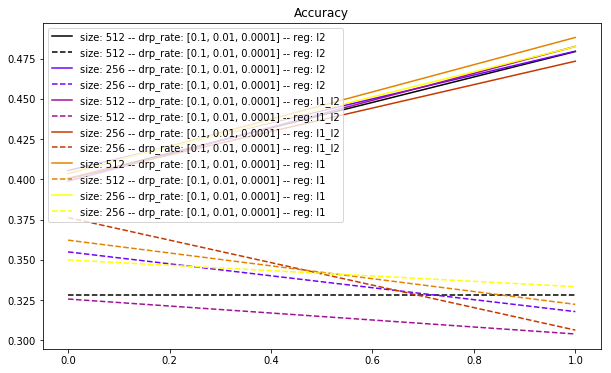

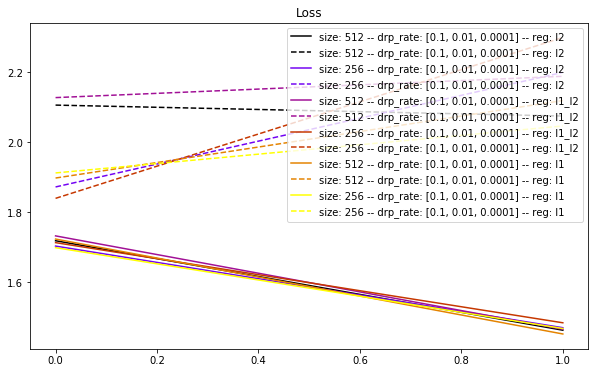

In [90]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
cmap = plt.get_cmap('gnuplot')
colors = [cmap(i) for i in np.linspace(0, 1, len(results))]

plt.figure(figsize=(10, 6))
for i, cond in enumerate(results.keys()):
    plt.plot(results[cond]['train_acc'], '-', label=cond, color=colors[i])
    plt.plot(results[cond]['test_acc'], '--', label=cond, color=colors[i])
plt.title("Accuracy")
plt.legend(loc="upper left")
plt.show()

plt.figure(figsize=(10, 6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train_loss'])),results[cond]['train_loss'], '-', label=cond, color=colors[i])
    plt.plot(range(len(results[cond]['test_loss'])),results[cond]['test_loss'], '--', label=cond, color=colors[i])
plt.title("Loss")
plt.legend(loc="upper right")
plt.show()